In [1]:
# Libraries 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset with error handling
dataset_path = "IMDAA_merged_1.08_1990_2020.nc"
try:
    ds = xr.open_dataset(dataset_path)
    print(f"Dataset loaded successfully: {dataset_path}")
    print(f"Dataset shape: {ds.dims}")
except FileNotFoundError:
    print(f"Error: Dataset file '{dataset_path}' not found.")
    print("Please ensure the dataset file is in the correct location.")
except Exception as e:
    print(f"Error loading dataset: {e}")

ds

<xarray.Dataset> Size: 742MB
Dimensions:   (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time      (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat       (latitude) float64 256B ...
    lon       (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 186MB ...
    TMP_prl   (time, latitude, longitude) float32 186MB ...
    TMP_2m    (time, latitude, longitude) float32 186MB ...
    APCP_sfc  (time, latitude, longitude) float32 186MB ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

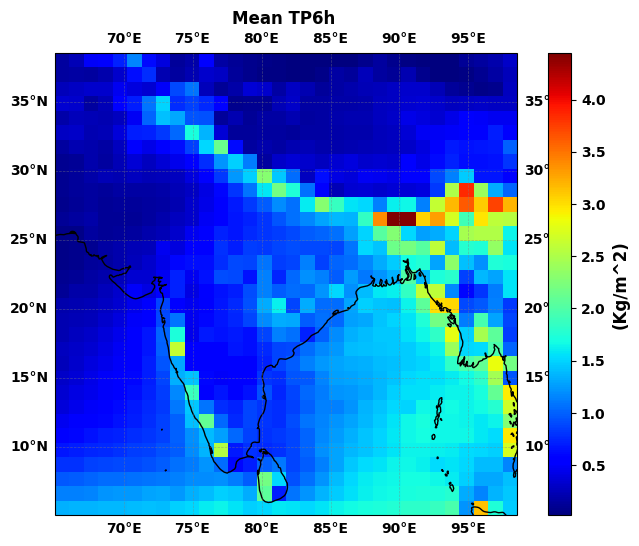

In [5]:

mean_all = ds.mean(dim='time')
z500 = mean_all
data_values = z500['APCP_sfc'].values

# Get the extent of your xarray dataset
lon_min, lon_max, lat_min, lat_max = z500.lon.min(), z500.lon.max(), z500.lat.min(), z500.lat.max()

# Create a basic plot within the extent of your xarray data using cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(data_values, cmap='jet', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())

ax.tick_params( labelcolor='black', labelsize='large', width=2)
# Add country borders and coastlines within the extent
ax.add_feature(cfeature.COASTLINE, linewidth=1)
#ax.add_feature(cfeature.BORDERS, linewidth=1)
#world.boundary.plot(ax=ax, linewidth=1, color='black')

# Add Cartopy graticules (latitude and longitude lines)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
#ax.set_xticks(range(int(lon_min), int(lon_max) + 1, 10), crs=ccrs.PlateCarree())
#ax.set_yticks(range(int(lat_min), int(lat_max) + 1, 10), crs=ccrs.PlateCarree())
# plt.xticks(fontweight='bold')
# plt.yticks(fontweight='bold')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('(Kg/m^2)', fontsize = 12, weight="bold")
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), weight="bold")
plt.title('Mean TP6h ' , fontweight='bold')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)
plt.savefig('TP6h.png', dpi = 600)
plt.show()



# Evaluation Metrics

In [6]:
def compute_rmse(prediction, actual,  mean_dims = ('time', 'latitude', 'longitude')):
  error = prediction - actual
  rmse = np.sqrt(((error)**2 ).mean(mean_dims))
  return rmse

In [7]:
def compute_mae(prediction, actual, mean_dims = ('time', 'latitude', 'longitude')):
    error = prediction - actual
    mae = np.abs(error).mean(mean_dims)
    return mae

In [8]:
def compute_acc(prediction, actual):
    clim = actual.mean('time')
    try:
        t = np.intersect1d(prediction.time, actual.time)
        pred_anomaly = prediction.sel(time=t) - clim
    except AttributeError:
        t = actual.time.values
        pred_anomaly = prediction - clim
    act_anomaly = actual.sel(time=t) - clim
    
    pred_norm = pred_anomaly - pred_anomaly.mean()
    act_norm = act_anomaly - act_anomaly.mean()

    acc = (
            np.sum(pred_norm * act_norm) /
            np.sqrt(
                np.sum(pred_norm ** 2) * np.sum(act_norm ** 2)
            )
    )
    return acc

# Basic Baseline Models

In [9]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')

In [10]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc'] # [H500, T850, T2m, TP6h]

## Persistence

In [11]:
# Each day the data has four observations at 00 UTC, 06 UTC, 12 UTC and 18 UTC
lead_time_steps = np.arange(4, 64, 4) 
lead_time_steps

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60])

In [12]:
# Compute the rmse for each lead_time_steps

df_error = pd.DataFrame()
for var in var_name:
    error_rmse = []
    error_mae = []
    error_acc = []
    for i,j in enumerate(lead_time_steps):

 # compute persistent forecast
        persistence_fc = ds.sel(time=test_years).isel(time=slice(0, -j))
        persistence_fc['time'] = persistence_fc.time + np.timedelta64(i+1, 'D').astype('timedelta64[ns]')
        target = ds.sel(time=test_years)
        target = target.isel(time=slice(j, None))
        # change the variable name according to the dataset
        error = compute_rmse(persistence_fc, target)[var].values.item() 
        error_rmse.append(error)
        error = compute_mae(persistence_fc, target)[var].values.item()
        error_mae.append(error)
        error = compute_acc(persistence_fc, target)[var].values.item()
        error_acc.append(error) 
    df_error[var+'_RMSE'] = error_rmse
    df_error[var+'_MAE'] = error_mae
    df_error[var+'_ACC'] = error_acc
    


In [13]:
df_error

,HGT_prl_RMSE,HGT_prl_MAE,HGT_prl_ACC,TMP_prl_RMSE,TMP_prl_MAE,TMP_prl_ACC,TMP_2m_RMSE,TMP_2m_MAE,TMP_2m_ACC,APCP_sfc_RMSE,APCP_sfc_MAE,APCP_sfc_ACC
0,18.921972,12.867607,0.937819,1.766601,1.163387,0.950545,1.864312,1.137101,0.965626,3.806400,1.033877,0.339989
1,28.510340,19.655811,0.858764,2.314061,1.547011,0.915044,2.332346,1.452980,0.946122,4.133322,1.211897,0.222661
2,32.766064,22.731606,0.813226,2.562181,1.741058,0.895676,2.549878,1.612043,0.935500,4.255882,1.286970,0.176849
3,34.702087,23.992290,0.790184,2.705870,1.848877,0.883452,2.674756,1.702413,0.928925,4.303292,1.316799,0.159332
4,36.091221,24.963800,0.772708,2.800397,1.915865,0.875019,2.755822,1.760073,0.924468,4.328154,1.336531,0.150426
5,37.325878,25.871527,0.756671,2.870447,1.965246,0.868554,2.810712,1.799744,0.921348,4.349452,1.353051,0.142846
6,38.179207,26.472309,0.745191,2.955242,2.018347,0.860523,2.886795,1.848029,0.916942,4.354096,1.364552,0.141640
7,38.460915,26.633411,0.741034,3.037963,2.075049,0.852448,2.966775,1.903098,0.912174,4.365153,1.370219,0.138028
8,38.413147,26.499733,0.741376,3.097834,2.117289,0.846412,3.038094,1.950528,0.907781,4.359684,1.369129,0.141178
9,38.653519,26.675587,0.737969,3.148584,2.154964,0.841179,3.100948,1.995462,0.903808,4.367540,1.375138,0.138937


In [14]:
df_error.iloc[[2, 4]]

,HGT_prl_RMSE,HGT_prl_MAE,HGT_prl_ACC,TMP_prl_RMSE,TMP_prl_MAE,TMP_prl_ACC,TMP_2m_RMSE,TMP_2m_MAE,TMP_2m_ACC,APCP_sfc_RMSE,APCP_sfc_MAE,APCP_sfc_ACC
2,32.766064,22.731606,0.813226,2.562181,1.741058,0.895676,2.549878,1.612043,0.935500,4.255882,1.286970,0.176849
4,36.091221,24.963800,0.772708,2.800397,1.915865,0.875019,2.755822,1.760073,0.924468,4.328154,1.336531,0.150426


In [15]:
df = pd.DataFrame({ 'Lead Days': np.arange(1, 16, 1),'RMSE': df_error['APCP_sfc_RMSE'], 'MAE': df_error['APCP_sfc_MAE'], 'ACC': df_error['APCP_sfc_ACC']})
df.head()


,Lead Days,RMSE,MAE,ACC
0,1,3.806400,1.033877,0.339989
1,2,4.133322,1.211897,0.222661
2,3,4.255882,1.286970,0.176849
3,4,4.303292,1.316799,0.159332
4,5,4.328154,1.336531,0.150426


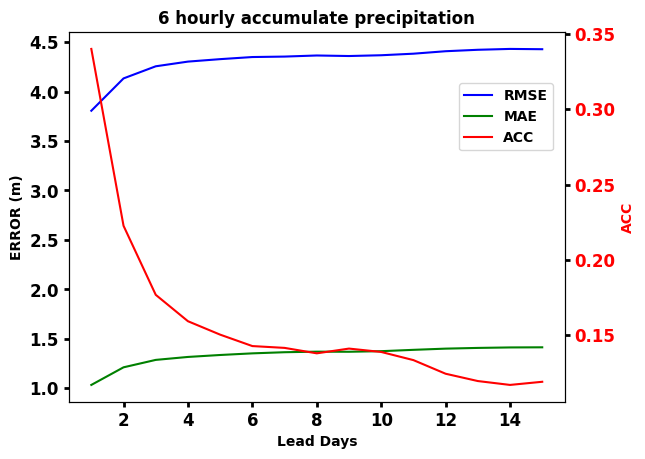

In [16]:
fig, ax1 = plt.subplots()

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold' )

ax1.plot(df['Lead Days'], df['RMSE'], label='RMSE', color='blue')
ax1.plot(df['Lead Days'], df['MAE'], label='MAE', color='green')
ax1.set_xlabel('Lead Days', fontweight='bold')
ax1.set_ylabel('ERROR (m)', color='black', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize='large', width=2 )
ax1.tick_params(axis='x', labelcolor='black', labelsize='large', width=2)

ax2 = ax1.twinx()
ax2.plot(df['Lead Days'], df['ACC'], label='ACC', color='red')
ax2.set_ylabel('ACC', color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize='large', width=2)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.99, 0.88))
# Make legend labels bold
for label in legend.get_texts():
    label.set_fontweight('bold')

 
ax1.set_title('6 hourly accumulate precipitation', fontweight='bold')

plt.yticks(fontweight='bold' )

plt.savefig(r'E:\4_Projects\1_Personal Projects\BharatBench_fork\figures\APCP_sfc_persistence.png', dpi=300)

plt.show()

## Climatology

In [17]:
clim = ds.sel(time=train_years).groupby('time.dayofyear').mean()
error_rmse = compute_rmse(clim.sel(dayofyear=ds.sel(time=test_years).time.dt.dayofyear), ds.sel(time=test_years))
error_mae = compute_mae(clim.sel(dayofyear=ds.sel(time=test_years).time.dt.dayofyear), ds.sel(time=test_years))
error_acc = compute_acc(clim.sel(dayofyear=ds.sel(time=test_years).time.dt.dayofyear), ds.sel(time=test_years)) 

In [18]:
df_error = pd.DataFrame()
for var in var_name:
    df_error[var] = pd.DataFrame({var: [error_rmse[var].values, error_mae[var].values, error_acc[var].values]}, index=['RMSE', 'MAE', 'ACC'])
df_error    

,HGT_prl,TMP_prl,TMP_2m,APCP_sfc
RMSE,28.474808,2.5178847,4.1353617,3.1779978
MAE,21.135199,1.7817136,2.8271973,1.1162522
ACC,0.85397005,0.8941324,0.81417847,0.28648072


In [19]:
print(f" Geopotential  Height at 500hPa \n RMSE : {error_rmse['HGT_prl'].values}\n MAE : {error_mae['HGT_prl'].values}\n ACC : {error_acc['HGT_prl'].values} ")
print(f" Temperature at  850hPa \n RMSE : {error_rmse['TMP_prl'].values}\n MAE : {error_mae['TMP_prl'].values}\n ACC : {error_acc['TMP_prl'].values} ")
print(f" Total Precipitation \n RMSE : {error_rmse['APCP_sfc'].values}\n MAE : {error_mae['APCP_sfc'].values}\n ACC : {error_acc['APCP_sfc'].values} ")
print(f" 2m Temperature \n RMSE : {error_rmse['TMP_2m'].values}\n MAE : {error_mae['TMP_2m'].values}\n ACC : {error_acc['TMP_2m'].values} ")

 Geopotential  Height at 500hPa 
 RMSE : 28.474807739257812
 MAE : 21.13519859313965
 ACC : 0.8539700508117676 
 Temperature at  850hPa 
 RMSE : 2.5178847312927246
 MAE : 1.781713604927063
 ACC : 0.8941323757171631 
 Total Precipitation 
 RMSE : 3.1779978275299072
 MAE : 1.1162521839141846
 ACC : 0.28648072481155396 
 2m Temperature 
 RMSE : 4.135361671447754
 MAE : 2.827197313308716
 ACC : 0.814178466796875 


## Weekly Climatology

In [20]:
# computation of weekly climatology
def compute_weekly_climatology(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [21]:
train_data = ds.sel(time=train_years)
target = ds.sel(time=test_years)

In [22]:
weekly_climatology = compute_weekly_climatology(train_data, target.time)

In [23]:
error_rmse = compute_rmse(weekly_climatology, target)
error_mae = compute_mae(weekly_climatology, target)
error_acc = compute_acc(weekly_climatology, target)

In [24]:
df_error = pd.DataFrame()
for var in var_name:
    df_error[var] = pd.DataFrame({var: [error_rmse[var].values, error_mae[var].values, error_acc[var].values]}, index=['RMSE', 'MAE', 'ACC'])
df_error 

,HGT_prl,TMP_prl,TMP_2m,APCP_sfc
RMSE,28.775707,2.5373142,4.1508703,3.16672
MAE,21.278955,1.7946957,2.8351948,1.1127037
ACC,0.8503811,0.892405,0.8126303,0.29468304


In [25]:
print(f" Geopotential  Height at 500hPa \n RMSE : {error_rmse['HGT_prl'].values}\n MAE : {error_mae['HGT_prl'].values}\n ACC : {error_acc['HGT_prl'].values} ")
print(f" Temperature at  850hPa \n RMSE : {error_rmse['TMP_prl'].values}\n MAE : {error_mae['TMP_prl'].values}\n ACC : {error_acc['TMP_prl'].values} ")
print(f" Total Precipitation \n RMSE : {error_rmse['APCP_sfc'].values}\n MAE : {error_mae['APCP_sfc'].values}\n ACC : {error_acc['APCP_sfc'].values} ")
print(f" 2m Temperature \n RMSE : {error_rmse['TMP_2m'].values}\n MAE : {error_mae['TMP_2m'].values}\n ACC : {error_acc['TMP_2m'].values} ")

 Geopotential  Height at 500hPa 
 RMSE : 28.775707244873047
 MAE : 21.278955459594727
 ACC : 0.850381076335907 
 Temperature at  850hPa 
 RMSE : 2.5373141765594482
 MAE : 1.7946957349777222
 ACC : 0.8924049735069275 
 Total Precipitation 
 RMSE : 3.166719913482666
 MAE : 1.1127036809921265
 ACC : 0.294683039188385 
 2m Temperature 
 RMSE : 4.150870323181152
 MAE : 2.8351948261260986
 ACC : 0.812630295753479 
